In [1]:
################
### PREAMBLE ###
################

%matplotlib inline
from __future__ import division
import tensorflow as tf
import numpy as np
import tarfile
import os
import matplotlib.pyplot as plt
import time

print ("Hello World")

Hello World


In [2]:
###################
### IMPORT DATA ###
###################

def csv_to_numpy_array(filePath, delimiter):
    return np.genfromtxt(filePath, delimiter=delimiter, dtype=None)

def import_data():
    if "data" not in os.listdir(os.getcwd()):
        # Untar directory of data if we haven't already
        tarObject = tarfile.open("data.tar.gz")
        tarObject.extractall()
        tarObject.close()
        print("Extracted tar to current directory")
    else:
        # we've already extracted the files
        pass

    print("loading training data")
    trainX = csv_to_numpy_array("data/trainX.csv", delimiter="\t")
    trainY = csv_to_numpy_array("data/trainY.csv", delimiter="\t")
    print("loading test data")
    testX = csv_to_numpy_array("data/testX.csv", delimiter="\t")
    testY = csv_to_numpy_array("data/testY.csv", delimiter="\t")
    return trainX,trainY,testX,testY

trainX,trainY,testX,testY = import_data()

loading training data
loading test data


In [3]:
#########################
### GLOBAL PARAMETERS ###
#########################

# DATA SET PARAMETERS
# Get our dimensions for our different variables and placeholders:
# numFeatures = the number of words extracted from each email
numFeatures = trainX.shape[1]
# numLabels = number of classes we are predicting (here just 2: Ham or Spam)
numLabels = trainY.shape[1]

# TRAINING SESSION PARAMETERS
# number of times we iterate through training data
# tensorboard shows that accuracy plateaus at ~25k epochs
numEpochs = 27000
# a smarter learning rate for gradientOptimizer
learningRate = tf.train.exponential_decay(learning_rate=0.0008,
                                          global_step= 1,
                                          decay_steps=trainX.shape[0],
                                          decay_rate= 0.95,
                                          staircase=True)

In [4]:
####################
### PLACEHOLDERS ###
####################

# X = X-matrix / feature-matrix / data-matrix... It's a tensor to hold our email
# data. 'None' here means that we can hold any number of emails
X = tf.placeholder(tf.float32, [None, numFeatures])
# yGold = Y-matrix / label-matrix / labels... This will be our correct answers
# matrix. Every row has either [1,0] for SPAM or [0,1] for HAM. 'None' here 
# means that we can hold any number of emails
yGold = tf.placeholder(tf.float32, [None, numLabels])

In [5]:
#################
### VARIABLES ###
#################

# Values are randomly sampled from a Gaussian with a standard deviation of:
#     sqrt(6 / (numInputNodes + numOutputNodes + 1))

weights = tf.Variable(tf.random_normal([numFeatures,numLabels],
                                       mean=0,
                                       stddev=(np.sqrt(6/numFeatures+
                                                         numLabels+1)),
                                       name="weights"))

bias = tf.Variable(tf.random_normal([1,numLabels],
                                    mean=0,
                                    stddev=(np.sqrt(6/numFeatures+numLabels+1)),
                                    name="bias"))

In [6]:
######################
### PREDICTION OPS ###
######################

# INITIALIZE our weights and biases
init_OP = tf.initialize_all_variables()

# PREDICTION ALGORITHM i.e. FEEDFORWARD ALGORITHM
apply_weights_OP = tf.matmul(X, weights, name="apply_weights")
add_bias_OP = tf.add(apply_weights_OP, bias, name="add_bias") 
activation_OP = tf.nn.sigmoid(add_bias_OP, name="activation")

In [7]:
#####################
### EVALUATION OP ###
#####################

# COST FUNCTION i.e. MEAN SQUARED ERROR
cost_OP = tf.nn.l2_loss(activation_OP-yGold, name="squared_error_cost")

In [8]:
#######################
### OPTIMIZATION OP ###
#######################

# OPTIMIZATION ALGORITHM i.e. GRADIENT DESCENT
training_OP = tf.train.GradientDescentOptimizer(learningRate).minimize(cost_OP)

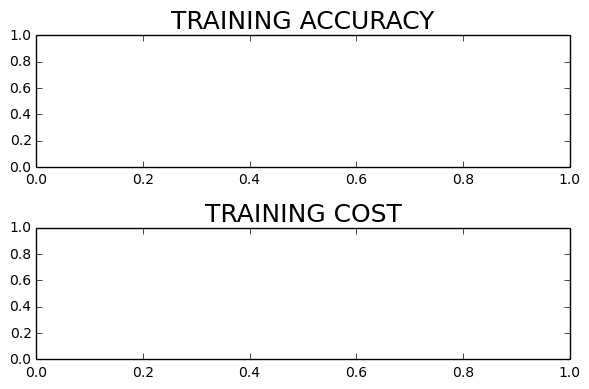

In [9]:
###########################
### GRAPH LIVE UPDATING ###
###########################

epoch_values=[]
accuracy_values=[]
cost_values=[]
# Turn on interactive plotting
plt.ion()
# Create the main, super plot
fig = plt.figure()
# Create two subplots on their own axes and give titles
ax1 = plt.subplot("211")
ax1.set_title("TRAINING ACCURACY", fontsize=18)
ax2 = plt.subplot("212")
ax2.set_title("TRAINING COST", fontsize=18)
plt.tight_layout()

In [10]:
#####################
### RUN THE GRAPH ###
#####################

# Create a tensorflow session
sess = tf.Session()

# Initialize all tensorflow variables
sess.run(init_OP)

## Ops for vizualization
# argmax(activation_OP, 1) gives the label our model thought was most likely
# argmax(yGold, 1) is the correct label
correct_predictions_OP = tf.equal(tf.argmax(activation_OP,1),tf.argmax(yGold,1))
# False is 0 and True is 1, what was our average?
accuracy_OP = tf.reduce_mean(tf.cast(correct_predictions_OP, "float"))
# Summary op for regression output
activation_summary_OP = tf.histogram_summary("output", activation_OP)
# Summary op for accuracy
accuracy_summary_OP = tf.scalar_summary("accuracy", accuracy_OP)
# Summary op for cost
cost_summary_OP = tf.scalar_summary("cost", cost_OP)
# Summary ops to check how variables (W, b) are updating after each iteration
weightSummary = tf.histogram_summary("weights", weights.eval(session=sess))
biasSummary = tf.histogram_summary("biases", bias.eval(session=sess))
# Merge all summaries
all_summary_OPS = tf.merge_all_summaries()
# Summary writer
writer = tf.train.SummaryWriter("summary_logs", sess.graph_def)

# Initialize reporting variables
cost = 0
diff = 1

# Training epochs
for i in range(numEpochs):
    if i > 1 and diff < .0001:
        print("change in cost %g; convergence."%diff)
        break
    else:
        # Run training step
        step = sess.run(training_OP, feed_dict={X: trainX, yGold: trainY})
        # Report occasional stats
        if i % 10 == 0:
            # Add epoch to epoch_values
            epoch_values.append(i)
            # Generate accuracy stats on test data
            summary_results, train_accuracy, newCost = sess.run(
                [all_summary_OPS, accuracy_OP, cost_OP], 
                feed_dict={X: trainX, yGold: trainY}
            )
            # Add accuracy to live graphing variable
            accuracy_values.append(train_accuracy)
            # Add cost to live graphing variable
            cost_values.append(newCost)
            # Write summary stats to writer
            writer.add_summary(summary_results, i)
            # Re-assign values for variables
            diff = abs(newCost - cost)
            cost = newCost

            #generate print statements
            print("step %d, training accuracy %g"%(i, train_accuracy))
            print("step %d, cost %g"%(i, newCost))
            print("step %d, change in cost %g"%(i, diff))

            # Plot progress to our two subplots
            accuracyLine, = ax1.plot(epoch_values, accuracy_values)
            costLine, = ax2.plot(epoch_values, cost_values)
            fig.canvas.draw()
            time.sleep(1)


# How well do we perform on held-out test data?
print("final accuracy on test set: %s" %str(sess.run(accuracy_OP, 
                                                     feed_dict={X: testX, 
                                                                yGold: testY})))

step 0, training accuracy 0.466946
step 0, cost 364.61
step 0, change in cost 364.61
step 10, training accuracy 0.466946
step 10, cost 350.784
step 10, change in cost 13.8257
step 20, training accuracy 0.466946
step 20, cost 339.386
step 20, change in cost 11.3989
step 30, training accuracy 0.466946
step 30, cost 328.389
step 30, change in cost 10.9967
step 40, training accuracy 0.466946
step 40, cost 315.319
step 40, change in cost 13.0695
step 50, training accuracy 0.466946
step 50, cost 298.316
step 50, change in cost 17.003
step 60, training accuracy 0.466946
step 60, cost 277.7
step 60, change in cost 20.6165
step 70, training accuracy 0.465897
step 70, cost 257.982
step 70, change in cost 19.718


KeyboardInterrupt: 

In [11]:
##############################
### SAVE TRAINED VARIABLES ###
##############################

# Create Saver
saver = tf.train.Saver()
# Save variables to .ckpt file
# saver.save(sess, "trained_variables.ckpt")

# Close tensorflow session
sess.close()